In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

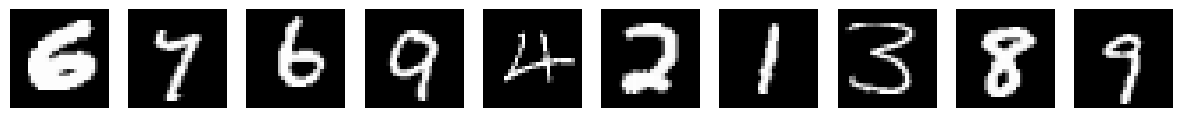

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

Epoch [10/10]: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it, loss=0.00312]


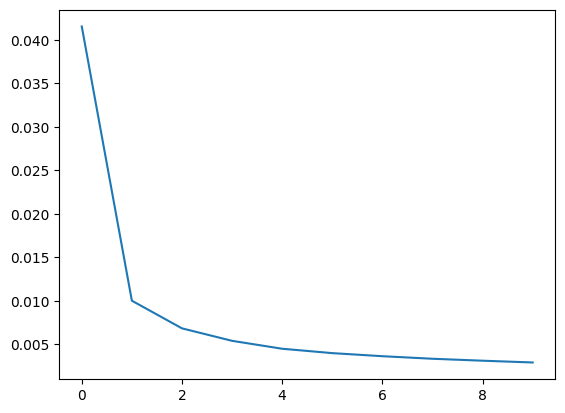

In [5]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 7, stride=1, padding=0),
            nn.ReLU(True),
            nn.Flatten(1),
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 1, 1)),
            nn.ConvTranspose2d(256, 128, 7, stride=1, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train():
    model = AE().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    

    EPOCHS = 10
    BATCH_SIZE = 128
    losses = []

    loop = tqdm(range(EPOCHS))
    for epoch in loop:
        epoch_losses = []
        loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}]')
        if epoch > 0:
            loop.set_postfix(loss=losses[-1])
        for x, _ in train_loader:

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, x)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        losses.append(sum(epoch_losses) / len(epoch_losses))



    return model, losses

ae, losses = train()
plt.plot(losses)

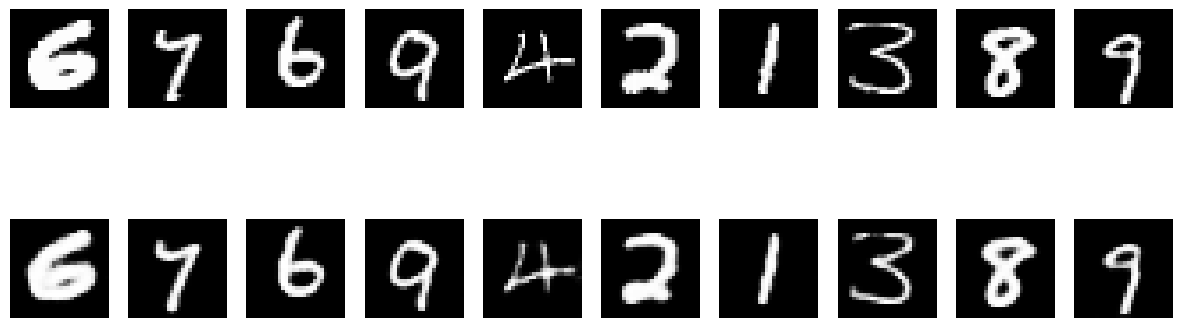

In [6]:
imgs = train_dataset.transformed_images[:10]
# reconstructed = ae(imgs.view(-1, 784)).view(-1, 1, 28, 28).cpu().detach()
reconstructed = ae(imgs).cpu().detach()

fig, axes = plt.subplots(2, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(imgs[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

In [7]:
all_stats = {}

In [8]:
def train(
        model,
        train_dataset,
        BATCH_SIZE,
        NUM_EPOCHS,
        optimiser,
        scheduler,
        stats,
        norm_grads=False,
        neg_cnst=None,
        cd=None,
):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    pos_states = [model.init_state(ae.encoder(images)) for images, _ in train_loader]
    neg_states = [model.init_state(ae.encoder(images)) for images, _ in train_loader]

    model.train()
    gamma = torch.ones(pos_states[0][0]['x'].shape[0], device=device) * model.gamma
    cd_gamma = torch.ones(pos_states[0][0]['x'].shape[0], device=device) * model.gamma

    loop = tqdm(range(NUM_EPOCHS), leave=False)
    for i in loop:

        if stats['epoch'] > 0:
            postfix = {'steps': i, 'posVFE': stats['posVfe'][-1]}
            if neg_cnst:
                postfix['negVFE'] = stats['negVfe'][-1]
                postfix['negMSE'] = stats['negMse'][-1]
            if cd:
                postfix['cdVFE'] = stats['cdVfe'][-1]
            loop.set_postfix(postfix)
        
        epoch_stats = {'posVfe': [], 'negVfe': [], 'cdVfe': [], 'negMse': []}
        
        for i in range(len(train_loader)):

            # Update particles and calculate new VFE
            model.step(pos_states[i], gamma, pin_obs=True)
            pos_vfe = model.vfe(pos_states[i], normalise=norm_grads)
            loss = pos_vfe.clone()

            # Same For Negative particles
            if neg_cnst:
                neg_states[i][-1]['x'] = pos_states[i][-1]['x']
                # for _ in range(20):
                model.step(neg_states[i], gamma, pin_target=True)
                neg_vfe = model.vfe(neg_states[i], normalise=norm_grads)
                reconstruction = neg_states[i][0]['x']
                neg_mse = F.mse_loss(reconstruction, pos_states[i][0]['x'])
                loss -= neg_cnst*neg_vfe
            if cd:
                cd_state = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[i]]
                # for _ in range(cd):
                #     model.step(cd_state, cd_gamma, pin_obs=False)
                
                out, _ = model.reconstruct(cd_state[0]['x'], steps=cd)
                cd_state[0]['x'] = out

                cd_vfe = model.vfe(cd_state, normalise=norm_grads)
                loss += -0.75 * cd_vfe

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if model.has_top:
                model.top.weight.data = model.top.weight.data - torch.diag(model.top.weight.data.diag())

            # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
            if norm_grads:
                pos_vfe = model.vfe(pos_states[i], normalise=False)
                if neg_cnst:
                    neg_vfe = model.vfe(neg_states[i], normalise=False)
                if cd:
                    cd_vfe = model.vfe(cd_state, normalise=False)
            

            assert pos_vfe.item() >= 0, f'VFE is negative: {pos_vfe.item()}'

            epoch_stats['posVfe'].append(pos_vfe.item())
            if neg_cnst:
                epoch_stats['negVfe'].append(neg_vfe.item())
                epoch_stats['negMse'].append(neg_mse.item())
            if cd:
                epoch_stats['cdVfe'].append(cd_vfe.item())

        pos_vfe = sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe'])
        if pos_vfe < 0:
            raise ValueError(f'epoch VFE is negative: {pos_vfe}')
        stats['posVfe'].append(sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe']))
        if neg_cnst:
            stats['negVfe'].append(sum(epoch_stats['negVfe']) / len(epoch_stats['negVfe'])) 
            stats['negMse'].append(sum(epoch_stats['negMse']) / len(epoch_stats['negMse']))
        if cd:
            stats['cdVfe'].append(sum(epoch_stats['cdVfe']) / len(epoch_stats['cdVfe']))

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['posVfe'][-1])
        
        stats['epoch'] += 1
    

In [13]:
torch.manual_seed(seed)

model_name = 'original'
model = FCPCN(
    # sizes=[INPUT_SHAPE, 1024, 512, 512],
    # precisions=[-9999, 4.0, 2.0, 7.0],
    sizes=[256, 128],
    precisions=[1.0, 1.0],
    bias=False, 
    symmetric=True,
    actv_fn=F.elu,
    steps=20,
    gamma=0.001,
    x_decay=0.0,
    dropout=0.0,
    has_top=False,
).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'negMse': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}
# model.load_state_dict(torch.load(f'examples/mnist/out/models/mnist_original.pth'))
# # Init particles
# pos_state = model.init_state(train_dataset.transformed_images.flatten(1).clone())
# neg_state = model.init_state(train_dataset.transformed_images.flatten(1).clone())

In [14]:
# NUM_EPOCHS = 10000
# BATCH_SIZE = 10000
NUM_EPOCHS = 10000
BATCH_SIZE = 48000
optimiser = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
train(
    model,
    train_dataset,
    BATCH_SIZE,
    NUM_EPOCHS,
    optimiser,
    # scheduler,
    None,
    stats,
    # pos_state,
    # neg_state,
    norm_grads=False,
    neg_cnst=None,
    cd=None,
)

Sparsities: [0.663221538066864, 0.0]
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)


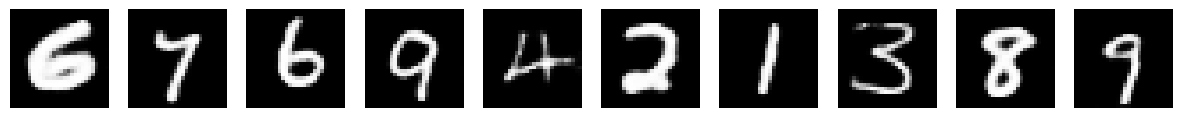

In [15]:
model.eval()
imgs = train_dataset.images.clone()
enc = ae.encoder(imgs)
out, state = model(enc, pin_obs=True, steps=100)

sparsity = [(torch.abs(layer['x']) == 0).float().mean().item() for layer in state]
print(f'Sparsities: {sparsity}')

reconstructions = ae.decoder(model.layers[1].predict(state[1]))
mse = F.mse_loss(reconstructions, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].detach().cpu(), cmap='gray')
    ax.axis('off')

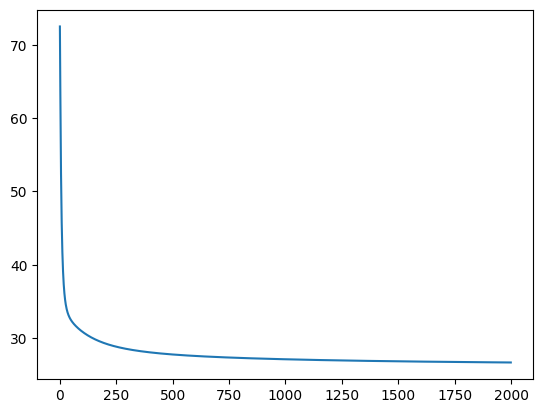

In [15]:
model.eval()
imgs = train_dataset.transformed_images.clone().flatten(1) + 0.3*torch.randn_like(train_dataset.transformed_images.clone().flatten(1))
state = model.init_state(imgs)

vfes = []
gamma = torch.ones(imgs.shape[0], device=device) * model.gamma
for _ in range(2000):
    model.step(state, gamma=gamma, pin_obs=True)
    vfes.append(model.vfe(state).item())

plt.plot(vfes)

tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)


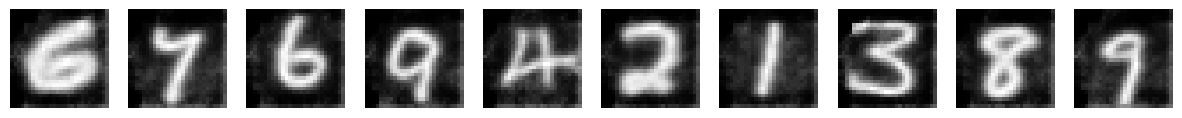

In [21]:
model.eval()
imgs = train_dataset.transformed_images.clone()
enc = ae.encoder(imgs)
out, state = model(enc, pin_obs=True, steps=2000)

out, state = model(y=out, pin_target=True, steps=200)
# out, state = model(imgs, y=out, steps=200)
reconstructions = ae.decoder(state[0]['x'])
mse = F.mse_loss(reconstructions, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].permute(1, 2, 0).detach().cpu(), cmap='gray')
    ax.axis('off')

vfe:  0.5378090143203735
final mse:  0.10572176426649094


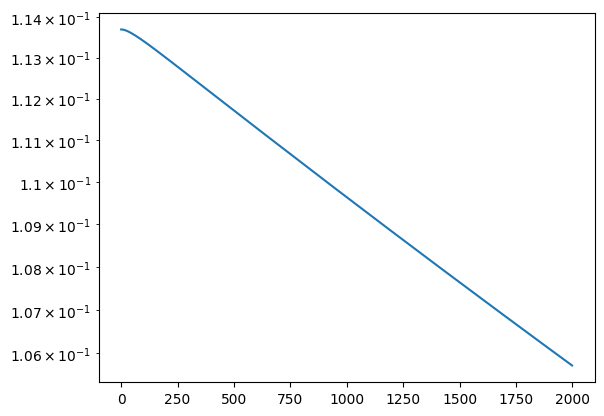

In [11]:
imgs = train_dataset.transformed_images.clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True, steps=2000)
print('vfe: ', model.vfe(state).item())

mse = []
state = model.init_state(y=out)
gamma = torch.ones(state[0]['x'].shape[0], device=device) * model.gamma
prev_vfe = None
with torch.no_grad():
    for _ in range(2000):
        model.step(state, gamma, pin_target=True)
        reconstructions = state[0]['x']
        mse.append(F.mse_loss(reconstructions, imgs).item())
        gamma, prev_vfe = model.update_gamma(state, gamma, prev_vfe)

print('final mse: ', mse[-1])
plt.plot(mse)
plt.yscale('log')

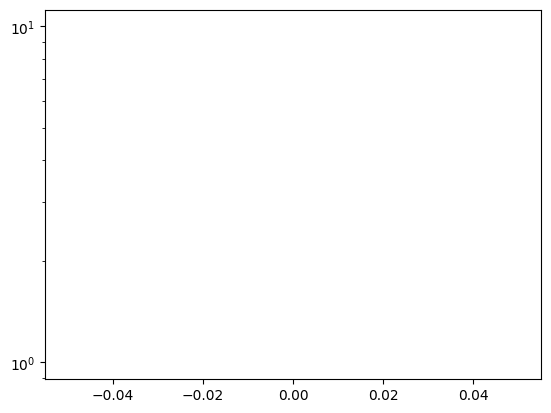

In [12]:
plt.plot(stats['negMse'])
plt.yscale('log')

In [12]:
all_stats['classic'] = stats

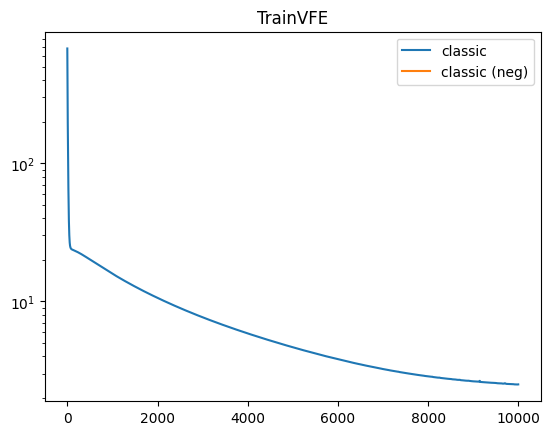

In [30]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

C:\Users\joeag\AppData\Local\Temp\ipykernel_24444\854850053.py:19: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([28, 28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  errs.append(F.mse_loss(F.normalize(img), F.normalize(og.cpu())).item())


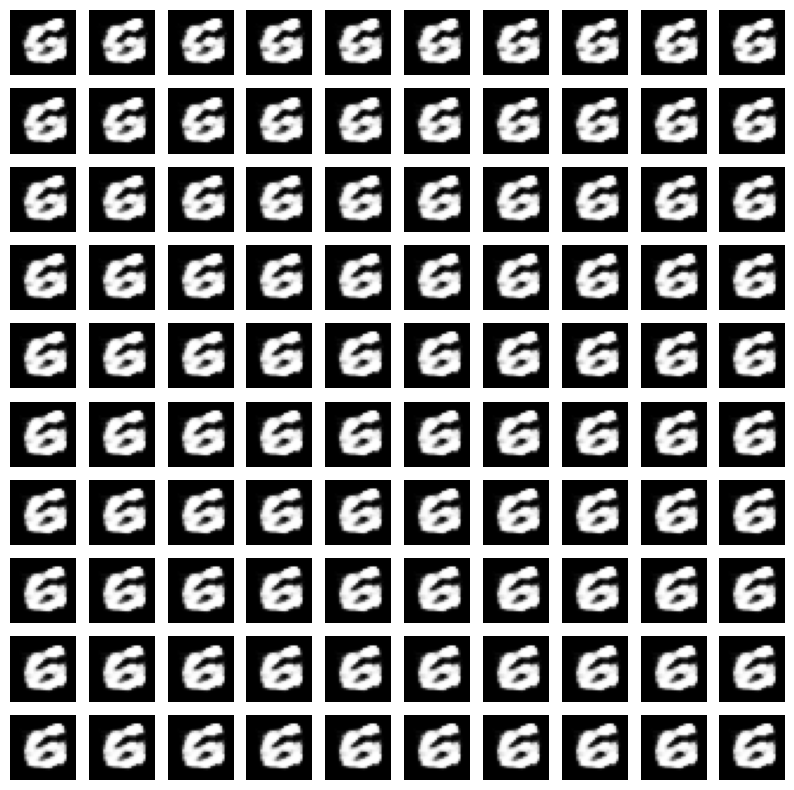

Final MSE:  0.31336042284965515
Final VFE:  3.585813522338867
Min MSE:  0.312127947807312
Min VFE:  3.585813522338867


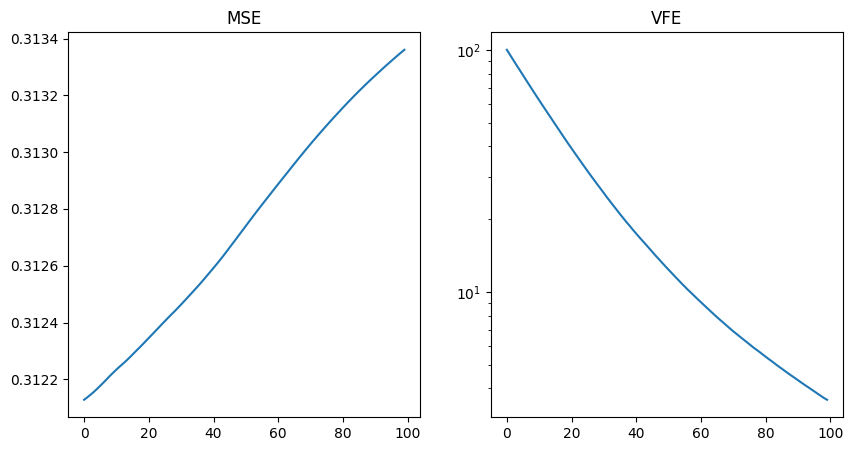

In [34]:
model.eval()
og = train_dataset.images[0].clone().unsqueeze(0)
noised = og + torch.randn_like(og) * 0.5
x = ae.encoder(noised.clone())
# x[torch.rand_like(x) > 0.7] = 0.0
# errs = [F.mse_loss(x, og).item()]
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = ae.decoder(x).squeeze(0).permute(1, 2, 0).cpu().detach()
        # img = (F.normalize(x.cpu(), 1).reshape(28,28).detach() - F.normalize(og.cpu(), 1).reshape(28,28).detach()).abs()
        ax2.imshow(img, cmap='gray')
        x, state = model.reconstruct(x, steps=200, beta=0.05)
        errs.append(F.mse_loss(F.normalize(img), F.normalize(og.cpu())).item())
        # errs.append(F.mse_loss(x, og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

print('Final MSE: ', errs[-1])
print('Final VFE: ', vfes[-1])
print('Min MSE: ', min(errs))
print('Min VFE: ', min(vfes))
# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'examples\mnist\out\models\mnist_original.pth')

In [14]:
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.01)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'trainLoss': stats['trainLoss'][-1], 'valLoss': stats['valLoss'][-1], 'valAcc': stats['valAcc'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images, steps=200)
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean().item())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_results = val_pass(model, classifier, valLoader, True, True, None)
        stats['valAcc'].append(val_results['acc'].item())
        stats['valLoss'].append(val_results['loss'].item())
        
        stats['epoch'] += 1

In [15]:
classifier = torch.nn.Sequential(
    # torch.nn.Linear(600, 200),
    # torch.nn.ReLU(),
    # torch.nn.Linear(200, 10, bias=False),
    torch.nn.Linear(128, 10, bias=False),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [16]:
NUM_EPOCHS = 30
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)

In [ ]:
plt.plot(class_stats['trainLoss'])
plt.show()
plt.plot(class_stats['valAcc'])